In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

import transformers
from transformers import AutoModel

C:\Users\polov\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_data, test_data = datasets.load_dataset("MonoHime/ru_sentiment_dataset", split=["train", "validation"]) # загрузка датасета

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tokenizer = torchtext.data.utils.get_tokenizer(word_tokenize) # загрузка токенизатора

In [6]:
tokenizer("привет мир!")

['привет', 'мир', '!']

In [7]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [8]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [9]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [10]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [11]:
import pickle

# Сохранение словаря
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [12]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [13]:
vocab.set_default_index(unk_index)

In [14]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [15]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [16]:
train_data = train_data.with_format(type="torch", columns=["ids", "sentiment"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "sentiment"])
test_data = test_data.with_format(type="torch", columns=["ids", "sentiment"])

In [18]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["sentiment"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "sentiment": batch_label}
        return batch

    return collate_fn

In [19]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [20]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [21]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [22]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique("sentiment"))
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Модель имеет {count_parameters(model):,} обучаемых параметров")

Модель имеет 35,955,303 обучаемых параметров


In [24]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [25]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(118347, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [26]:
vectors = torchtext.vocab.GloVe()

In [27]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [28]:
model.embedding.weight.data = pretrained_embedding

In [29]:
optimizer = optim.Adam(model.parameters())

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [32]:
model = model.to(device)
criterion = criterion.to(device)

In [33]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="обучение..."):
        ids = batch["ids"].to(device)
        label = batch["sentiment"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [34]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="эволюция..."):
            ids = batch["ids"].to(device)
            label = batch["sentiment"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [35]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [36]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:30<00:00,  2.26s/it]


epoch: 0
train_loss: 0.859, train_acc: 0.593
valid_loss: 0.627, valid_acc: 0.714


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [07:22<00:00,  4.76s/it]


epoch: 1
train_loss: 0.561, train_acc: 0.753
valid_loss: 0.559, valid_acc: 0.750


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:01<00:00,  1.96s/it]


epoch: 2
train_loss: 0.427, train_acc: 0.822
valid_loss: 0.570, valid_acc: 0.755


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [05:22<00:00,  3.47s/it]


epoch: 3
train_loss: 0.321, train_acc: 0.874
valid_loss: 0.621, valid_acc: 0.751


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:07<00:00,  2.02s/it]


epoch: 4
train_loss: 0.238, train_acc: 0.912
valid_loss: 0.708, valid_acc: 0.746


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:02<00:00,  1.96s/it]


epoch: 5
train_loss: 0.185, train_acc: 0.935
valid_loss: 0.798, valid_acc: 0.739


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [04:18<00:00,  2.78s/it]


epoch: 6
train_loss: 0.153, train_acc: 0.950
valid_loss: 0.867, valid_acc: 0.738


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:06<00:00,  2.01s/it]


epoch: 7
train_loss: 0.133, train_acc: 0.958
valid_loss: 0.930, valid_acc: 0.731


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:09<00:00,  2.04s/it]


epoch: 8
train_loss: 0.118, train_acc: 0.964
valid_loss: 0.979, valid_acc: 0.730


эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [03:23<00:00,  2.19s/it]

epoch: 9
train_loss: 0.105, train_acc: 0.968
valid_loss: 1.014, valid_acc: 0.731


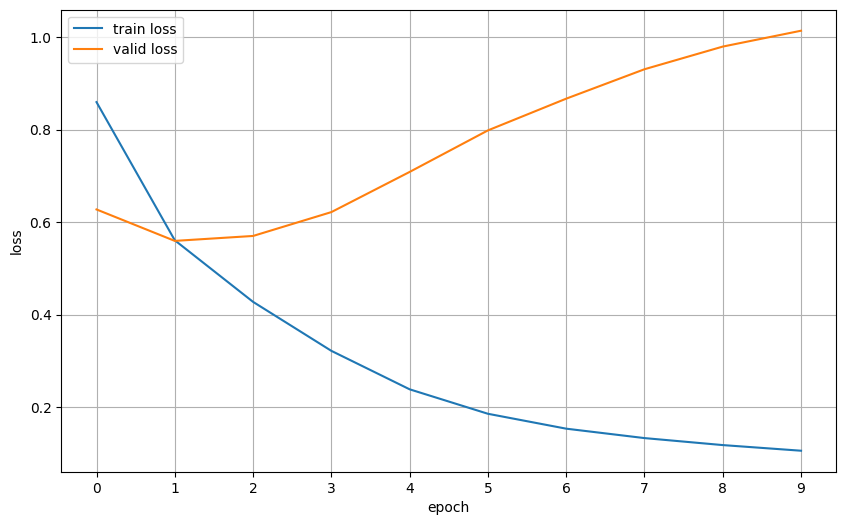

In [37]:


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()



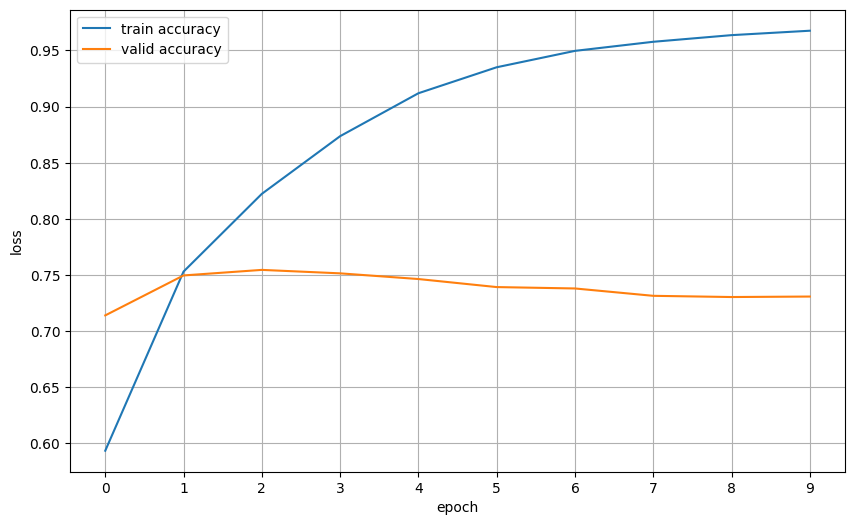

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [39]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

эволюция...: 100%|█████████████████████████████████████████████████████████████████████| 42/42 [01:42<00:00,  2.44s/it]


In [40]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.562, test_acc: 0.747


In [41]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [42]:
text = "Этот фильм был просто потрясающим! Я наслаждался каждой минутой просмотра."
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)
#0: нейтральный
#1: позитивный
#2: негативный
# (1- негативный, 0.9464174509048462 - точность результата) 

(1, 0.8270149827003479)

In [43]:
text = "Обслуживание в этом ресторане оставляет желать лучшего. Официанты были невнимательными и невежливыми."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(2, 0.9464174509048462)

In [44]:
text = "Сервис в этом отеле был идеальным. Все сотрудники были очень внимательны и дружелюбны."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.871134340763092)

In [45]:
text = "сегодня дождь"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.39617010951042175)

In [50]:
text = "Качество товара оказалось намного хуже, чем я ожидал. Разочарован этой покупкой."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(2, 0.695357620716095)

In [51]:
text = "Я очень доволен результатами своей работы. Команда справилась с задачей на отлично."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.9596788883209229)

In [52]:
text = "Эта книга вызвала у меня много эмоций. Я плакал и смеялся, читая каждую страницу."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.4132162034511566)

In [53]:
text = "Моя поездка в отпуск была полна приключений и позитивных эмоций. Отличное время!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.49520382285118103)

In [54]:
text = "Я разочарован качеством услуг данной компании. Их подход к работе оставляет желать лучшего."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(2, 0.8124067783355713)

In [56]:
text = "кафедра О7 лучшая в мире."

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.7469510436058044)

In [57]:
text = "не люблю физику"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.5189254283905029)

In [58]:
text = "ненавижу ошибки в коде"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(2, 0.4776305556297302)